# Valuing On-Ball-Actions

This notebook demonstrates how to value on-the-ball actions of football players with the open-source [VAEP framework](https://github.com/ML-KULeuven/socceraction) using the publicly available [Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000). The Wyscout dataset includes data for the 2017/2018 English Premier League, the 2017/2018 Spanish Primera División, the 2017/2018 German 1. Bundesliga, the 2017/2018 Italian Serie A, the 2017/2018 French Ligue 1, the 2018 FIFA World Cup, and the UEFA Euro 2016. Covering 1,941 matches, 3,251,294 events and 4,299 players, the dataset is large enough to train machine-learning models and obtain robust ratings for the players.


**References:**
* Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. "[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)" In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
* Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. "[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions.](https://www.nature.com/articles/s41597-019-0247-7)" *Scientific Data 6*, no. 1 (2019): 1-15.

In [ ]:
!pip install tables==3.6.1
!pip install socceraction==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.2 MB/s eta 0:00:00
  Created wheel for socceraction: filename=socceraction-0.2.0-py3-none-any.whl size=30641 sha256=4049a1dc70d2c1c52e3858e7c5fb43fd0404f04ec276cf642c44d717fbadb12c
  Stored in directory: /root/.cache/pip/wheels/53/cd/73/194cae13cd5b3448a32f952f684ff7038a7afd183e542c5bb1
Successfully built socceraction


In [ ]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

In [ ]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

# Download and preprocess the data

This section downloads the Wyscout dataset, collects the required information about the match events, and converts the match events into the SPADL representation.

1. Download the Wyscout dataset;
2. Construct an HDF5 file named `wyscout.h5` that contains the relevant information from the dataset;
3. Convert the `wyscout.h5` file into a `spadl.h5` file that contains the same information in the SPADL representation.

**Note:** The `socceraction` library offers off-the-shelf functionality to convert a collection of Wyscout JSON files into the SPADL representation. However, the JSON files in the publicly available dataset are not directly compatible with the `socceraction` functionality. Therefore, we need to perform a few additional steps to transform the Wyscout data into the SPADL representation.

## Download the Wyscout dataset

The `data_files` `dict` lists the four data files in the Wyscout dataset that are required to run the VAEP framework.
* `events` (73.74 MB): match events for the matches in the dataset;
* `matches` (629.98 kB): overview of the matches in the dataset;
* `players` (1.66 MB): information on the players in the dataset;
* `teams` (26.76 kB): information on the teams in the dataset.

In [ ]:
data_files = {
    'events': 'https://ndownloader.figshare.com/files/14464685',  # ZIP file containing one JSON file for each competition
    'matches': 'https://ndownloader.figshare.com/files/14464622',  # ZIP file containing one JSON file for each competition
    'players': 'https://ndownloader.figshare.com/files/15073721',  # JSON file
    'teams': 'https://ndownloader.figshare.com/files/15073697'  # JSON file
}

The following cell loops through the `data_files` `dict`, downloads each listed data file, and stores each downloaded data file to the local file system.

If the downloaded data file is a ZIP archive, the included JSON files are extracted from the ZIP archive and stored to the local file system.

**Note:** If you do not understand what the code below does exactly, then do not worry too much. ;-)

In [ ]:
for url in tqdm(data_files.values()):
    url_s3 = urlopen(url).geturl()
    path = Path(urlparse(url_s3).path)
    file_name = path.name
    file_local, _ = urlretrieve(url_s3, file_name)
    if is_zipfile(file_local):
        with ZipFile(file_local) as zip_file:
            zip_file.extractall()

  0%|          | 0/4 [00:00<?, ?it/s]

## Preprocess the Wyscout data

The `read_json_file` function reads and returns the content of a given JSON file. The function handles the encoding of special characters (e.g., accents in names of players and teams) that the `pd.read_json` function cannot handle properly.

In [ ]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

### Teams

The following cells read the `teams.json` file into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `teams`.

In [ ]:
json_teams = read_json_file('teams.json')
df_teams = pd.read_json(json_teams)

In [ ]:
df_teams.head(10)

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
5,Troyes,Troyes,3795,Espérance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
6,Getafe (Madrid),Getafe,698,Getafe Club de Fútbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
7,Mönchengladbach,Borussia M'gladbach,2454,Borussia VfL Mönchengladbach,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
9,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [ ]:
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')

### Players

The following cells read the `players.json` file into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `players`.

In [ ]:
json_players = read_json_file('players.json')
df_players = pd.read_json(json_players)

In [ ]:
df_players.head(10)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null
5,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",83,Jasper,,Cillessen,676,1989-04-22,185,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",33,right,J. Cillessen,664
6,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",91,Toby,,Alderweireld,1624,1989-03-02,187,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",36,right,T. Alderweireld,5629
7,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",88,Jan,,Vertonghen,1624,1987-04-24,189,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",48,left,J. Vertonghen,5629
8,"{'name': 'France', 'id': '250', 'alpha3code': ...",74,Alexander,,Djiku,3783,1994-08-09,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",229427,right,A. Djiku,null
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712


In [ ]:
df_players.to_hdf('wyscout.h5', key='players', mode='a')

### Matches

The following cell lists the competitions to be included in the dataset. Uncomment the competitions that you want to include in your dataset.

In [ ]:
competitions = [
#     'England',
#     'France',
#     'Germany',
#     'Italy',
    'Spain',
    'European Championship',
    'World Cup'
]

The following cells read the `matches.json` files for the selected competitions into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `matches`.

In [ ]:
dfs_matches = []
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)
df_matches = pd.concat(dfs_matches)

In [ ]:
df_matches.head(10)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId,groupName
0,Played,4406122,38,"{'676': {'scoreET': 0, 'coachId': 92894, 'side...",181144,2018-05-20 18:45:00,676,Camp Nou,2565922,"Barcelona - Real Sociedad, 1 - 0","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 398931, 'role': 'referee'}, {'r...",Regular,795,NaN
1,Played,4406122,38,"{'679': {'scoreET': 0, 'coachId': 3427, 'side'...",181144,2018-05-20 16:30:00,0,Estadio Wanda Metropolitano,2565925,"Atlético Madrid - Eibar, 2 - 2","May 20, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 395056, 'role': 'referee'}, {'r...",Regular,795,NaN
2,Played,4406122,38,"{'691': {'scoreET': 0, 'coachId': 444778, 'sid...",181144,2018-05-20 14:15:00,691,San Mamés Barria,2565919,"Athletic Club - Espanyol, 0 - 1","May 20, 2018 at 4:15:00 PM GMT+2","[{'refereeId': 384957, 'role': 'referee'}, {'r...",Regular,795,NaN
3,Played,4406122,38,"{'674': {'scoreET': 0, 'coachId': 210074, 'sid...",181144,2018-05-20 10:00:00,674,Estadio de Mestalla,2565924,"Valencia - Deportivo La Coruña, 2 - 1","May 20, 2018 at 12:00:00 PM GMT+2","[{'refereeId': 398913, 'role': 'referee'}, {'r...",Regular,795,NaN
4,Played,4406122,38,"{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",181144,2018-05-19 18:45:00,0,Estadio de la Cerámica,2565927,"Villarreal - Real Madrid, 2 - 2","May 19, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 395085, 'role': 'referee'}, {'r...",Regular,795,NaN
5,Played,4406122,38,"{'696': {'scoreET': 0, 'coachId': 230918, 'sid...",181144,2018-05-19 16:30:00,680,Estadio Ramón Sánchez Pizjuán,2565920,"Sevilla - Deportivo Alavés, 1 - 0","May 19, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 379388, 'role': 'referee'}, {'r...",Regular,795,NaN
6,Played,4406122,38,"{'698': {'scoreET': 0, 'coachId': 4107, 'side'...",181144,2018-05-19 16:30:00,698,Estadio La Rosaleda,2565921,"Málaga - Getafe, 0 - 1","May 19, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 398919, 'role': 'referee'}, {'r...",Regular,795,NaN
7,Played,4406122,38,"{'714': {'scoreET': 0, 'coachId': 4258, 'side'...",181144,2018-05-19 16:30:00,756,Estadio de Gran Canaria,2565923,"Las Palmas - Girona, 1 - 2","May 19, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 381854, 'role': 'referee'}, {'r...",Regular,795,NaN
8,Played,4406122,38,"{'684': {'scoreET': 0, 'coachId': 0, 'side': '...",181144,2018-05-19 14:15:00,712,Estadio Municipal de Butarque,2565926,"Leganés - Real Betis, 3 - 2","May 19, 2018 at 4:15:00 PM GMT+2","[{'refereeId': 381927, 'role': 'referee'}, {'r...",Regular,795,NaN
9,Played,4406122,38,"{'692': {'scoreET': 0, 'coachId': 3880, 'side'...",181144,2018-05-19 11:00:00,692,Estadio de Balaídos,2565918,"Celta de Vigo - Levante, 4 - 2","May 19, 2018 at 1:00:00 PM GMT+2","[{'refereeId': 395078, 'role': 'referee'}, {'r...",Regular,795,NaN


In [ ]:
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')

### Events

The following cells read the `events.json` files for the selected competitions into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `events/match_<match-id>`.

In [ ]:
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(file_events)
    df_events = pd.read_json(json_events)
    df_events_matches = df_events.groupby('matchId', as_index=False)
    for match_id, df_events_match in df_events_matches:
        df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

## Convert the Wyscout data to the SPADL representation

The following cell calls the `convert_to_spadl` function from the `socceraction` library to convert the `wyscout.h5` HDF5 file into the `spadl.h5` HDF5 file.

In [ ]:
convert_to_spadl('wyscout.h5', 'spadl.h5')

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████| 495/495 [00:48<00:00, 10.16game/s]


...Converting events to actions


100%|██████████| 495/495 [05:36<00:00,  1.47game/s]


# Value game states

This section generates features and labels for the game states, trains a predictive machine learning model for each label, and values the game states by applying the trained machine learning models.

1. Generate the features to describe the game states;
2. Generate the labels that capture the value of the game states;
3. Compose a dataset by selecting a set of features and the labels of the game states;
4. Train predictive machine learning models using the dataset;
5. Value the game states using the trained predictive machine learning model.

**Note:** The code in this section is based on the [2-compute-features-and-labels.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/2-compute-features-and-labels.ipynb) and [3-estimate-scoring-and-conceding-probabilities.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/3-estimate-scoring-and-conceding-probabilities.ipynb) notebooks in the `socceraction` repository.

In [ ]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_actiontypes = pd.read_hdf('spadl.h5', key='actiontypes')
df_bodyparts = pd.read_hdf('spadl.h5', key='bodyparts')
df_results = pd.read_hdf('spadl.h5', key='results')

In [ ]:
df_results

,result_id,result_name
0,0,fail
1,1,success
2,2,offside
3,3,owngoal
4,4,yellow_card
5,5,red_card


In [ ]:
nb_prev_actions = 3

## Generate game state features

The following cell lists a number of *feature generators* from the `features` module in the `socceraction` library. Each function expects either a `DataFrame` object containing actions (i.e., individual actions) or a list of `DataFrame` objects containing consecutive actions (i.e., game states), and returns the corresponding *feature* for the individual action or game state.

In [ ]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

The following cell generates game states from consecutive actions in each game and computes the features for each game state.

1. Obtain the actions for the game (i.e., `df_actions`) by looping through the games;
2. Construct game states of a given length from the actions (i.e., `dfs_gamestates`);
3. Compute the features for the constructed game states (i.e., `df_features`) by looping through the list of *feature generators*.

In [ ]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )

    dfs_gamestates = features.gamestates(df_actions, nb_prev_actions=nb_prev_actions)
    dfs_gamestates = features.play_left_to_right(dfs_gamestates, game['home_team_id'])

    df_features = pd.concat([function(dfs_gamestates) for function in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/495 [00:00<?, ?it/s]

In [ ]:
dfs_gamestates[0]

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,type_name,result_name,bodypart_name
0,2057954.0,1.0,1.656214,16521.0,122671.0,52.50,34.00,36.75,31.96,0,0,1,pass,success,foot
1,2057954.0,1.0,4.487814,16521.0,139393.0,36.75,31.96,78.75,55.08,0,0,1,pass,success,foot
2,2057954.0,1.0,6.524990,16521.0,122847.0,78.75,55.08,66.15,56.44,0,21,1,dribble,success,foot
3,2057954.0,1.0,8.562167,16521.0,122847.0,66.15,56.44,74.55,57.80,0,0,1,pass,success,foot
4,2057954.0,1.0,10.991292,16521.0,122832.0,74.55,57.80,96.60,60.52,0,0,1,pass,success,foot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,2057954.0,2.0,2868.496551,14358.0,103682.0,76.65,19.04,81.90,20.40,0,0,1,pass,success,foot
1216,2057954.0,2.0,2870.980334,16521.0,122577.0,23.10,47.60,24.15,42.84,0,9,0,tackle,fail,foot
1217,2057954.0,2.0,2872.843120,16521.0,122577.0,24.15,42.84,24.15,42.84,0,8,1,foul,success,foot
1218,2057954.0,2.0,2939.438099,14358.0,257800.0,85.05,22.44,105.00,30.60,0,13,1,shot_freekick,success,foot


## Generate game state labels

The following cell lists a number of *label generators* from the `labels` module in the `socceraction` library. Each function expects either a `DataFrame` object containing actions (i.e., individual actions) or a list of `DataFrame` objects containing consecutive actions (i.e., game states), and returns the corresponding *label* for the individual action or game state.

In [ ]:
functions_labels = [
    labels.scores,
    labels.concedes
]

The following cell computes the labels for each action:

1. Obtain the actions for the game (i.e., `df_actions`) by looping through the games;
2. Compute the labels for the actions (i.e., `df_labels`) by looping through the list of *label generators*.

In [ ]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )

    df_labels = pd.concat([function(df_actions) for function in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/495 [00:00<?, ?it/s]

## Generate dataset

The following cell generates a list of names for the features to be included in the dataset.

In [ ]:
columns_features = features.feature_column_names(functions_features, nb_prev_actions=nb_prev_actions)

The following cell obtains the relevant features for each game and stores them in the `df_features` `DataFrame` object.

In [ ]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    dfs_features.append(df_features[columns_features])
df_features = pd.concat(dfs_features).reset_index(drop=True)

  0%|          | 0/495 [00:00<?, ?it/s]

In [ ]:
df_features.head(10)

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,68.133435,0.241882,68.133435,0.241882,68.133435,0.241882,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,41.747768,0.753381,68.133435,0.241882,68.133435,0.241882,True,True,3.146075,3.146075
2,True,False,False,False,False,False,False,False,False,False,...,39.962482,1.017502,41.747768,0.753381,68.133435,0.241882,True,True,3.238664,6.384739
3,False,False,True,False,False,False,False,False,False,False,...,80.147936,0.410167,90.620086,0.384605,79.833427,0.365852,False,False,15.901476,19.140140
4,True,False,False,False,False,False,False,False,False,False,...,78.506876,0.428778,80.147936,0.410167,90.620086,0.384605,True,False,0.962895,16.864371
5,True,False,False,False,False,False,False,False,False,False,...,37.401797,0.666390,46.843672,0.770906,44.874175,0.792647,False,False,1.073154,2.036049
6,True,False,False,False,False,False,False,False,False,False,...,37.799688,0.913326,37.401797,0.666390,46.843672,0.770906,True,False,0.681584,1.754738
7,True,False,False,False,False,False,False,False,False,False,...,73.221396,0.370616,87.194131,0.350260,79.056274,0.296788,False,False,0.722439,1.404023
8,True,False,False,False,False,False,False,False,False,False,...,75.931980,0.347241,73.221396,0.370616,87.194131,0.350260,True,False,2.634260,3.356699
9,False,False,False,False,False,False,False,False,False,False,...,50.065582,0.746548,42.387092,0.655581,45.319675,0.625097,False,False,1.968882,4.603142


In [ ]:
len(df_features)

618551

The following cell lists the names of the labels to be included in the dataset.

In [ ]:
columns_labels = [
    'scores',
    'concedes'
]

The following cell obtains the relevant labels for each game and stores them in the `df_labels` `DataFrame` object.

In [ ]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    dfs_labels.append(df_labels[columns_labels])
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

  0%|          | 0/495 [00:00<?, ?it/s]

In [ ]:
df_labels.head(10)

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


In [ ]:
len(df_labels)

618551

## Train classifiers

### XGBoost Classifier

The following cell trains an XGBoost classifier for each label using the computed features. For each label:
1. Construct an XGBoost classifier with default hyperparameters;
2. Train the classifier using the computed features and the label;
3. Store the trained classifier in the `models` `dict`.

 *CPU times: user 30min 46s, sys: 10.3 s, total: 30min 56s*

**Wall time: 18min 19s**


In [ ]:
%%time
models = {}
for column_labels in columns_labels:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(df_features, df_labels[column_labels])
    models[column_labels] = model

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


CPU times: user 29min 23s, sys: 8.93 s, total: 29min 31s
Wall time: 17min 33s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

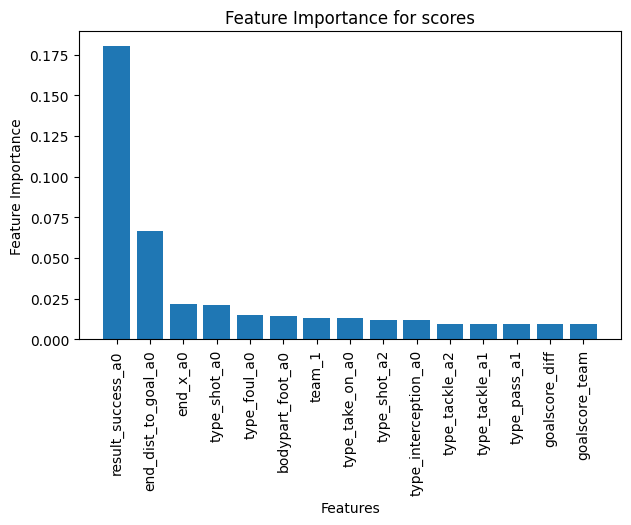

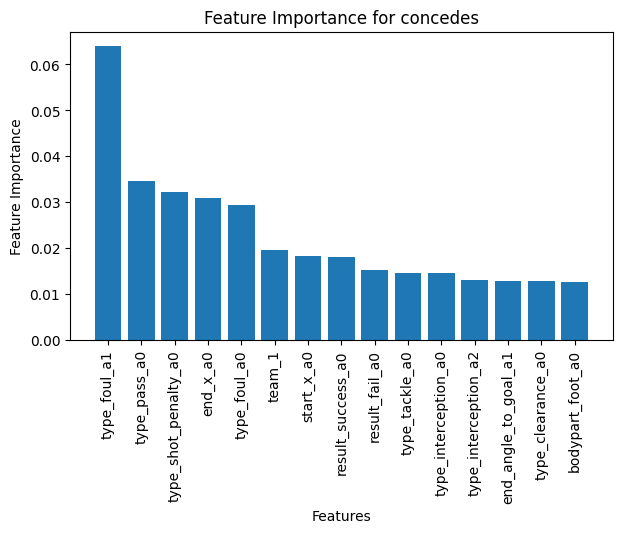

In [ ]:
# Initialize a dictionary to store feature importances for each column label
feature_importances_dict = {}

# Loop through the models and extract feature importances
for column_labels, model in models.items():
    feature_importances = model.feature_importances_
    feature_names = df_features.columns
    feature_importances_dict[column_labels] = dict(zip(feature_names, feature_importances))

# Plot feature importances for each column label
for column_labels, importances in feature_importances_dict.items():
    importances_sorted = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)[:15]}
    plt.figure(figsize=(7, 4))
    plt.bar(importances_sorted.keys(), importances_sorted.values())
    plt.xlabel('Features')
    plt.ylabel('Feature Importance')
    plt.title(f'Feature Importance for {column_labels}')
    plt.xticks(rotation=90)
    plt.show()







### Logistic Regression

**Wall time: 7min 44s**

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
models_lg = {}
for column_labels in tqdm(columns_labels):
    model = LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        random_state = 42,
        l1_ratio = 0.5
    )
    model.fit(df_features, df_labels[column_labels])
    models_lg[column_labels] = model

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CPU times: user 7min 39s, sys: 3.83 s, total: 7min 43s
Wall time: 7min 44s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(





## Estimate probabilities

The following cell predicts the labels for the game states using the trained XGBoost classifier. For each label:
1. Retrieve the model for the label;
2. Estimate the probabilities of the labels being `False` and `True` given the computed features;
3. Keep the probabilities for the `True` label;
4. Store the probabilities as a `Series` object in the `dfs_predictions` `dict`.

### XGBoost Estimates

In [ ]:
dfs_predictions = {}
for column_labels in columns_labels:
    model = models[column_labels]
    probabilities = model.predict_proba(df_features)
    predictions = probabilities[:, 1]
    dfs_predictions[column_labels] = pd.Series(predictions)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [ ]:
df_predictions.head(10)

,scores,concedes
0,0.001089,0.000333
1,0.008107,0.000199
2,0.010470,0.000695
3,0.006155,0.000208
4,0.001349,0.001487
5,0.007558,0.009232
6,0.008389,0.005309
7,0.004429,0.000886
8,0.003511,0.007392
9,0.001615,0.005282


The following cell obtains the `game_id` for each action in order to store the predictions per game.

In [ ]:
dfs_game_ids = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    dfs_game_ids.append(df_actions['game_id'])
df_game_ids = pd.concat(dfs_game_ids, axis=0).astype('int').reset_index(drop=True)

  0%|          | 0/495 [00:00<?, ?it/s]

The following cell concatenates the `DataFrame` objects with predictions and `game_id`s for each action into a single `DataFrame` object.

In [ ]:
df_predictions = pd.concat([df_predictions, df_game_ids], axis=1)

In [ ]:
df_predictions.head(10)

,scores,concedes,game_id
0,0.001089,0.000333,2565922
1,0.008107,0.000199,2565922
2,0.010470,0.000695,2565922
3,0.006155,0.000208,2565922
4,0.001349,0.001487,2565922
5,0.007558,0.009232,2565922
6,0.008389,0.005309,2565922
7,0.004429,0.000886,2565922
8,0.003511,0.007392,2565922
9,0.001615,0.005282,2565922


The following cell groups the predictions per game based on their `game_id`.

In [ ]:
df_predictions_per_game = df_predictions.groupby('game_id')

The following cell stores the predictions in the `predictions.h5` HDF5 file per game.

In [ ]:
for game_id, df_predictions in tqdm(df_predictions_per_game):
    df_predictions = df_predictions.reset_index(drop=True)
    df_predictions[columns_labels].to_hdf('predictions.h5', key=f'game_{game_id}')

  0%|          | 0/495 [00:00<?, ?it/s]

### Logistic Regression Estimates

In [ ]:
dfs_predictions_lg = {}
for column_labels in columns_labels:
    model = models_lg[column_labels]
    probabilities = model.predict_proba(df_features)
    predictions = probabilities[:, 1]
    dfs_predictions_lg[column_labels] = pd.Series(predictions)
dfs_predictions_lg = pd.concat(dfs_predictions_lg, axis=1)

In [ ]:
dfs_predictions_lg.head(10)

,scores,concedes
0,0.006374,0.006275
1,0.009451,0.002165
2,0.014383,0.001997
3,0.002111,0.008852
4,0.003013,0.008074
5,0.017006,0.002701
6,0.019426,0.002394
7,0.004164,0.010040
8,0.003795,0.006504
9,0.010835,0.003822


In [ ]:
df_predictions_lg_per_game = pd.concat([dfs_predictions_lg, df_game_ids], axis=1)
df_predictions_lg_per_game.head(10)

,scores,concedes,game_id
0,0.006374,0.006275,2565922
1,0.009451,0.002165,2565922
2,0.014383,0.001997,2565922
3,0.002111,0.008852,2565922
4,0.003013,0.008074,2565922
5,0.017006,0.002701,2565922
6,0.019426,0.002394,2565922
7,0.004164,0.010040,2565922
8,0.003795,0.006504,2565922
9,0.010835,0.003822,2565922


In [ ]:
df_predictions_lg_per_game = df_predictions_lg_per_game.groupby('game_id')

In [ ]:
for game_id, df_predictions in tqdm(df_predictions_lg_per_game):
    df_predictions = df_predictions.reset_index(drop=True)
    df_predictions[columns_labels].to_hdf('predictions_lg.h5', key=f'game_{game_id}')

  0%|          | 0/495 [00:00<?, ?it/s]

# Value on-the-ball actions

**Note:** The code in this section is based on the [4-compute-vaep-values.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/4-compute-vaep-values.ipynb) notebook in the `socceraction` repository.

In [ ]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

## Using XGBoost Model

In [ ]:
dfs_values = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .merge(df_players, how='left')
        .merge(df_teams, how='left')
        .reset_index(drop=True)
    )

    df_predictions = pd.read_hdf('predictions.h5', key=f'game_{game_id}')
    df_values = value(df_actions, df_predictions['scores'], df_predictions['concedes'])

    df_all = pd.concat([df_actions, df_predictions, df_values], axis=1)
    dfs_values.append(df_all)

  0%|          | 0/495 [00:00<?, ?it/s]

In [ ]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [ ]:
df_values[
    ['short_name', 'scores', 'concedes', 'offensive_value', 'defensive_value', 'vaep_value']
].head(10)

,short_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,O. Giroud,0.003943,0.001178,0.000000,-0.000000,0.000000
1,A. Griezmann,0.014103,0.001815,0.010160,-0.000637,0.009524
2,N. Kanté,0.002796,0.002793,-0.011307,-0.000979,-0.012286
3,L. Koscielny,0.003755,0.001286,0.000959,0.001507,0.002466
4,P. Evra,0.001512,0.000650,0.001512,-0.000650,0.000862
5,C. Săpunaru,0.001066,0.007324,0.000416,-0.005813,-0.005396
6,C. Săpunaru,0.000285,0.019753,-0.000782,-0.012429,-0.013211
7,B. Matuidi,0.016997,0.001214,-0.002757,-0.000930,-0.003686
8,C. Tătărușanu,0.002294,0.037343,0.001079,-0.020346,-0.019267
9,C. Tătărușanu,0.004514,0.022892,0.002220,0.014451,0.016671


## Using Logisitic Regression Model

In [ ]:
dfs_values = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .merge(df_players, how='left')
        .merge(df_teams, how='left')
        .reset_index(drop=True)
    )

    df_predictions = pd.read_hdf('predictions_lg.h5', key=f'game_{game_id}')
    df_values = value(df_actions, df_predictions['scores'], df_predictions['concedes'])

    df_all = pd.concat([df_actions, df_predictions, df_values], axis=1)
    dfs_values.append(df_all)

  0%|          | 0/495 [00:00<?, ?it/s]

In [ ]:
df_values_lg = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [ ]:
df_values_lg[
    ['short_name', 'scores', 'concedes', 'offensive_value', 'defensive_value', 'vaep_value']
].head(10)

,short_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,O. Giroud,0.010448,0.007415,0.000000,-0.000000,0.000000
1,A. Griezmann,0.007846,0.006919,-0.002603,0.000496,-0.002107
2,N. Kanté,0.005205,0.007161,-0.002641,-0.000241,-0.002882
3,L. Koscielny,0.013388,0.002236,0.008184,0.004925,0.013108
4,P. Evra,0.023045,0.001113,0.023045,-0.001113,0.021932
5,C. Săpunaru,0.000945,0.016186,-0.000168,0.006859,0.006691
6,C. Săpunaru,0.001459,0.015035,0.000514,0.001151,0.001665
7,B. Matuidi,0.099148,0.001506,0.084112,-0.000047,0.084065
8,C. Tătărușanu,0.001089,0.018877,-0.000417,0.080270,0.079854
9,C. Tătărușanu,0.001695,0.014883,0.000606,0.003994,0.004600


# Rate players

**Note:** The code in this section is based on the [5-top-players.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/5-top-players.ipynb) notebook in the `socceraction` repository.

## Rate according to total VAEP value

### Using XGBoost

In [ ]:
df_ranking = (df_values[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [ ]:
df_ranking.head(10)

,player_id,team_name,short_name,vaep_count,vaep_sum
0,3359.0,FC Barcelona,L. Messi,2753,37.998187
1,3682.0,Club Atlético de Madrid,A. Griezmann,1394,17.046918
2,3840.0,Real Club Celta de Vigo,Iago Aspas,1771,16.655736
3,3676.0,Real Sociedad de Fútbol,Illarramendi,3172,15.913620
4,14723.0,Real Madrid Club de Fútbol,T. Kroos,2496,15.138516
5,70129.0,Valencia Club de Fútbol,Rodrigo,1334,13.036405
6,3443.0,Club Atlético de Madrid,Koke,2510,11.927517
7,5400.0,Reial Club Deportiu Espanyol,Gerard Moreno,1724,11.438740
8,3310.0,Real Madrid Club de Fútbol,Marcelo,2340,11.175006
9,3322.0,Real Madrid Club de Fútbol,Cristiano Ronaldo,1182,11.141401


### Using Logistic Regression

In [ ]:
df_ranking_lg = (df_values_lg[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [ ]:
df_ranking_lg.head(10)

,player_id,team_name,short_name,vaep_count,vaep_sum
0,3359.0,FC Barcelona,L. Messi,2753,25.683768
1,3676.0,Real Sociedad de Fútbol,Illarramendi,3172,21.490542
2,140046.0,SD Eibar,M. Dmitrović,1306,19.240765
3,214062.0,Girona FC,Álex Granell,2314,19.079249
4,254.0,Málaga Club de Fútbol,R. Rosales,2385,18.940296
5,3325.0,Real Club Deportivo de La Coruña,Juanfran,2411,18.629851
6,3963.0,CD Leganés,Cuéllar,1266,18.411681
7,364860.0,Villarreal Club de Fútbol,Rodri,2986,17.614680
8,5472.0,Málaga Club de Fútbol,Luis Hernández,1867,17.466827
9,3827.0,Real Club Celta de Vigo,Hugo Mallo,2680,17.049003


## Rate according to total VAEP value per 90 minutes

### Using XGBoost

In [ ]:
df_player_games = pd.read_hdf('spadl.h5', 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [ ]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [ ]:
df_minutes_played.head(10)

,player_id,minutes_played
0,12,186.155078
1,33,92.903192
2,36,1029.522083
3,48,936.629337
4,54,373.883818
5,66,405.000000
6,93,612.996011
7,97,280.211195
8,99,103.097068
9,122,479.357303


In [ ]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played'] > 360]
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] / (df_ranking_p90['minutes_played'] / 90)
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)

In [ ]:
df_ranking_p90.head(10)

,player_id,team_name,short_name,vaep_count,vaep_sum,minutes_played,vaep_rating
0,3359.0,FC Barcelona,L. Messi,2753,37.998187,3486.545778,0.980867
116,8945.0,England,K. Trippier,447,5.207096,541.159246,0.865990
154,25714.0,France,D. Payet,438,4.367842,516.544493,0.761030
159,353833.0,France,K. Mbappé,261,4.091339,554.434820,0.664137
282,20879.0,Belgium,R. Nainggolan,230,2.550465,376.263702,0.610056
253,326523.0,Real Madrid Club de Fútbol,Dani Ceballos,446,2.802790,420.702252,0.599595
96,25707.0,Belgium,E. Hazard,798,6.233336,990.097625,0.566611
33,280383.0,Levante UD,E. Bardhi,975,9.736426,1638.749361,0.534724
333,4113.0,Athletic Club Bilbao,Etxeita,229,2.147955,385.970963,0.500856
128,225946.0,Real Betis Balompié,A. Sanabria,239,5.013569,901.735926,0.500392


In [ ]:
df_ranking_p90.to_csv('ranking.csv', index=False)

### Using Logistic Regression

In [ ]:
df_ranking_p90_lg = df_ranking_lg.merge(df_minutes_played)
df_ranking_p90_lg = df_ranking_p90_lg[df_ranking_p90_lg['minutes_played'] > 360]
df_ranking_p90_lg['vaep_rating'] = df_ranking_p90_lg['vaep_sum'] / (df_ranking_p90_lg['minutes_played'] / 90)
df_ranking_p90_lg = df_ranking_p90_lg.sort_values('vaep_rating', ascending=False)

In [ ]:
df_ranking_p90_lg.head(10)

,player_id,team_name,short_name,vaep_count,vaep_sum,minutes_played,vaep_rating
405,40810.0,Brazil,Neymar,406,4.185037,478.146889,0.787736
339,14716.0,Germany,J. Boateng,778,5.286636,677.790412,0.701983
0,3359.0,FC Barcelona,L. Messi,2753,25.683768,3486.545778,0.662988
436,25714.0,France,D. Payet,438,3.700447,516.544493,0.644746
525,62071.0,Republic of Ireland,D. Randolph,143,2.647400,372.939344,0.638887
527,703.0,Japan,M. Yoshida,354,2.637541,377.080735,0.629517
538,8480.0,Denmark,K. Schmeichel,170,2.546480,373.883818,0.612980
282,38021.0,Belgium,K. De Bruyne,778,6.846486,1029.522083,0.598514
2,3676.0,Real Sociedad de Fútbol,Illarramendi,3172,21.490542,3277.363401,0.590154
546,25816.0,Mexico,G. Ochoa,148,2.467063,378.512558,0.586600
